In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import colorsys
import itertools

from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb,lab2lch,rgb2hsv,hsv2rgb,lch2lab,lab2xyz,xyz2rgb
import matplotlib.pylab as plt
import os
import pickle
from itertools import permutations
import pandas as pd
import object_extract as oe
import cv2
import json

# Count Frist

lch range 0-100, 0-100, 0-2*pi
rgb range 0-255, 0-255, 0-255
lab range 0-100,-128-127,-128-127
hsv range 0-1, ,0-1,0-1

In [2]:
def labandlch_divideandcolor(color_number,start,end):
    cspace = end-start  # Total range
    segment_size = cspace / color_number

    print(segment_size)
    r_ranges = [[]for _ in range(len(start))]
    for i in range(len(start)):
        start_rgb = start[i]
        for j in range(color_number):
            start_rgb = start[i] + j * segment_size[i]
            end_rgb = start_rgb + segment_size[i]
            r_ranges[i].append([start_rgb, end_rgb])
            #if j != 0:
                #r_ranges[i].append([start_rgb+1, end_rgb])
            #else:
                #r_ranges[i].append([start_rgb, end_rgb])

        if end_rgb <end[i]:
            r_ranges[i].pop(-1)
            r_ranges[i].append([start_rgb,end[i]])

    lab_ranges = list(itertools.product(*r_ranges))
    #print(lab_ranges)
    colors = []
    for rgb_range in lab_ranges:
        l = rgb_range[0][0] + (rgb_range[0][1] -rgb_range[0][0]) /2
        a = rgb_range[1][0]+ (rgb_range[1][1] -rgb_range[1][0]) /2
        b = rgb_range[2][0] + (rgb_range[2][1] -rgb_range[2][0]) /2

        colors.append([l,a,b])

    color_labels = []
    colors = [[[i]] for i in colors]
    for i in range(1, len(colors) + 1):
        color_labels.append(f"color{i}")
    return lab_ranges,color_labels,colors

def color_plt(color_number,colors):
    cols = int(color_number/8)
    fig, ax = plt.subplots(figsize=(15, 4), nrows=8, ncols=cols)
    flag = 0
    for i in range(8):
        for j in range(cols):
            ax[i,j].imshow(colors[flag])
            ax[i,j].set_axis_off()
            flag +=1

    #fig.savefig('../Result/HSV/full_figure2.png')

    plt.show()

def range_upperandbottom(rgb_ranges):
    upper_list = []
    down_list = []
    for rgb_range in rgb_ranges:
        rgb_down = [rgb_range[0][0],rgb_range[1][0],rgb_range[2][0]]
        rgb_upper = [rgb_range[0][1],rgb_range[1][1],rgb_range[2][1]]

        upper_list.append(rgb_upper)
        down_list.append(rgb_down)
    down_np,upper_np = np.array(down_list),np.array(upper_list)
    return down_np,upper_np

In [3]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(4,np.array([0,0,0]),np.array([255,255,255]))

[63.75 63.75 63.75]


In [7]:
down_np,upper_np = range_upperandbottom(lab_ranges)

In [11]:
def rgb_pixel_count(down_list,upper_list,rgb):
    counts = []
    for down,upper in zip(down_list,upper_list):
        dst = cv2.inRange(rgb, down, upper)
        count = np.sum(dst==255)

        counts.append(count)

    return np.array(counts).astype(np.float64).reshape((1,-1)) / np.sum(counts)

def city_multiobjs_object_extraction(semantic_img,original_img,lower,upper,threshold,down_list,upper_list):
    se_img = imread(semantic_img)
    #print(se_img.shape)
    masks = np.zeros((se_img.shape[0],se_img.shape[1]))
    for i in range(len(lower)):
        #print(lower[i],upper[i])
        masks += cv2.inRange(se_img, lower[i], upper[i])

    positions = np.where(masks == 255)
    lens = len(positions[0])
    if lens > threshold:
        ori_img = imread(original_img)
        hsv_img = rgb2hsv(ori_img)
        colors = hsv_img[positions]
        colors = colors.reshape(-1,1,3)
        rgb_counts = rgb_pixel_count(down_list = down_list,
                                     upper_list = upper_list,
                                     rgb=colors)
        return 1,rgb_counts
    else:
        return 0,0

def city_multiobjs_feature_extract(objs,map_dict,root_dir,semantic_dir,original_dir,minus,add,threshold,down_list,upper_list):
    lower  = []
    upper = []
    k = len(down_list)
    for obj in objs:
        rgb_value = map_dict[obj]
        lower.append(rgb_value - minus)
        upper.append(rgb_value + add)

    cities = os.listdir(root_dir)
    city_count_map = {}
    for city in cities:
        count = np.zeros((1,k))
        se_dir = semantic_dir + '/' + city
        ori_dir = original_dir + '/' + city
        im_names = os.listdir(ori_dir)
        for i in range(len(im_names)):
            name = im_names[i]
            img_se_dir = se_dir + '/' + name
            img_ori_dir = ori_dir + '/' + name
            #print(name)
            _,rgb = city_multiobjs_object_extraction(semantic_img=img_se_dir,
                                                  original_img=img_ori_dir,
                                                  lower=lower,
                                                  upper=upper,
                                                  threshold=threshold,
                                                down_list=down_list,
                                                upper_list=upper_list)

            if _ != 0:
                count = np.concatenate((count,rgb))
        city_count_map[city] = count[1:]
        print(f'{city} is done')
    return city_count_map

In [16]:
folder_path1 = "E:/dataset/color_harmony_dataset/Seasons/Spring/Original/"
folder_path2 = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Semantic/'
root_dir = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Original'
path2csv = f'../Semantic_color_map/color_coding_semantic_segmentation_classes - Sheet1.csv'
object2color = oe.get_rgbandclass(path2csv)
minus = np.array([3, 3, 3])
add = np.array([4, 4, 4])

In [18]:
city_count_map = city_multiobjs_feature_extract(
                                                objs=['tree','grass'],
    root_dir=root_dir,
                                                 map_dict=object2color,
                                                 semantic_dir = folder_path2,
                                                 original_dir = folder_path1,
                                                 minus=minus,
                                                 add = add,
                                                 threshold=0,
    down_list = down_np,
                                upper_list = upper_np
                                                 )

Bangkok is done
Barcelona is done
Boston is done
Brussels is done
BuenosAires is done
Chicago is done
Lisbon is done
London is done
LosAngeles is done
Madrid is done
Medellin is done
Melbourne is done
MexicoCity is done
Miami is done
Minneapolis is done
Osaka is done
OSL is done
Phoenix is done


In [19]:



with open(r"E:/pythonproject/color_harmony/Result/HSV/Overall/city_each_pixelcount_tree_lch.pickle", "wb") as input_file:
  e = pickle.dump(city_count_map,input_file)

In [8]:
with open(r"E:/pythonproject/color_harmony/Result/HSV/Overall/city_each_pixelcount_tree_lch.pickle", "rb") as input_file:
  e = pickle.load(input_file)

In [9]:
city_each_map ={}

In [10]:
for city in e.keys():
    city_each_map[city] = np.sum(e[city],axis=0) / len(e[city])

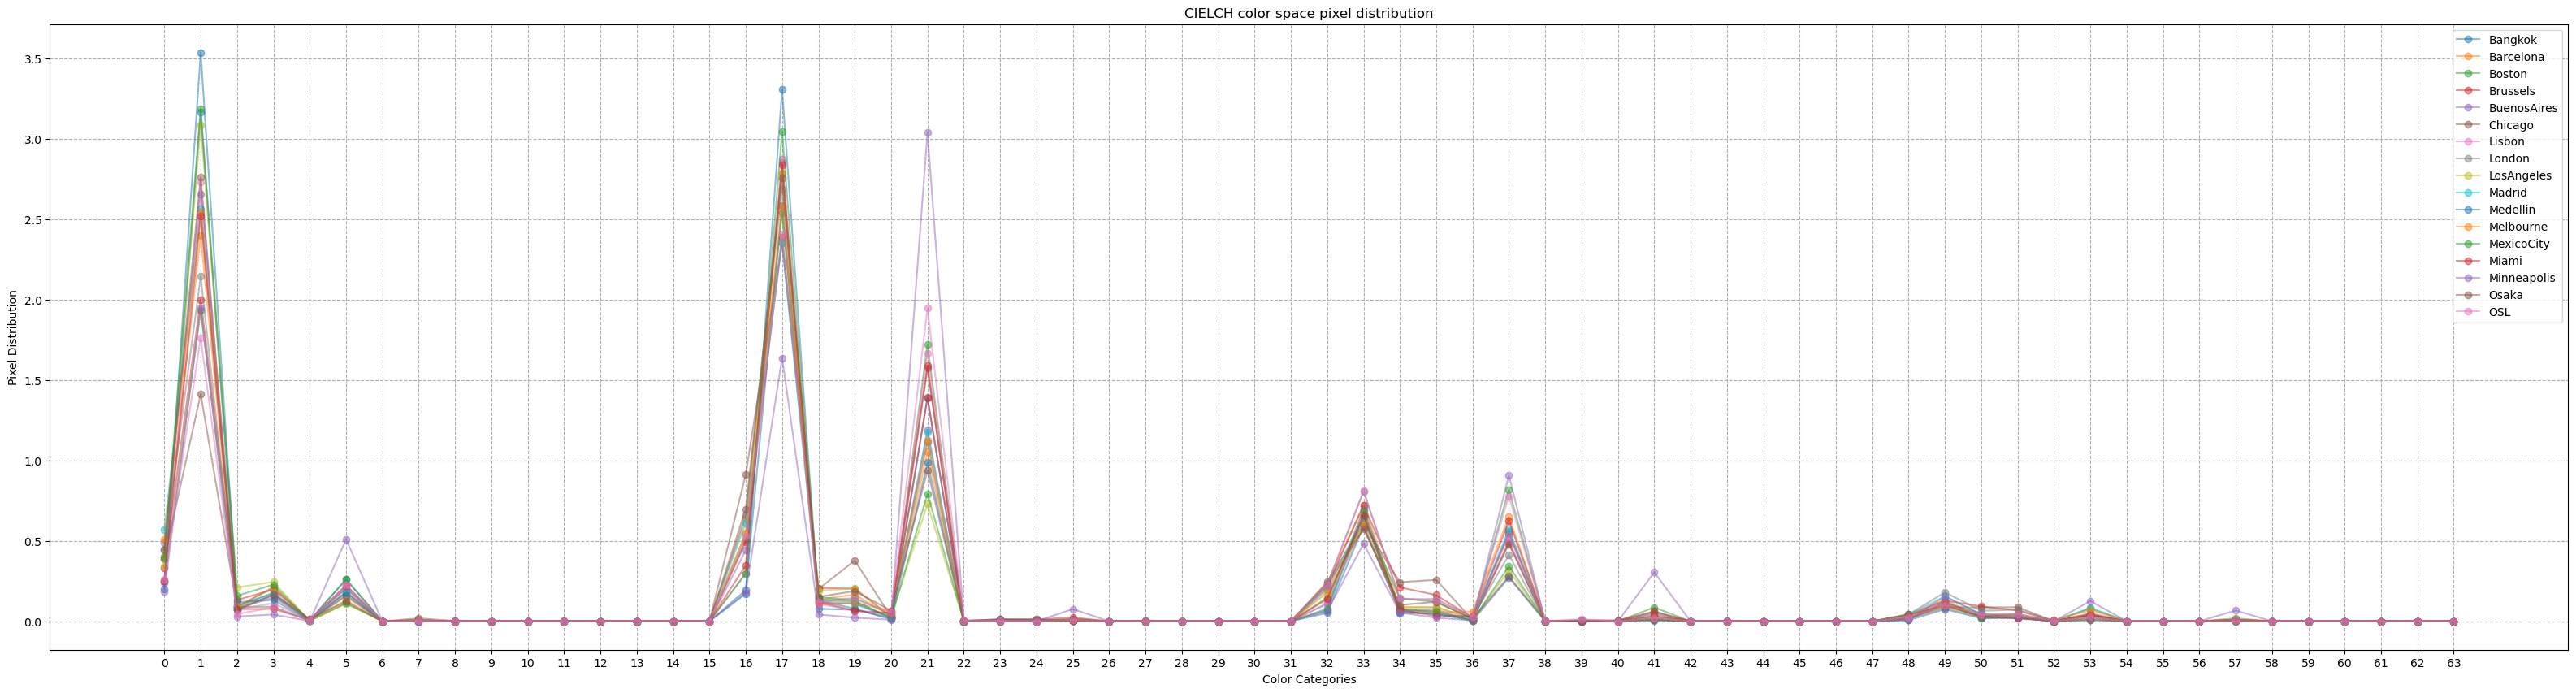

In [11]:
plt.rcParams["figure.figsize"] = (40,10)

fig, ax = plt.subplots()

for city in city_each_map.keys():
    data = city_each_map[city].reshape(-1,)
    ax.plot(list(range(64)), data*10, label=city, marker='o',alpha=0.5)

ax.set_ylabel('Pixel Distribution')
ax.set_xticks(range(64))
#ax.set_xticklabels(color_labels, rotation='vertical')
ax.set_xlabel('Color Categories')
ax.tick_params(axis='y')

plt.legend()
plt.grid(ls='--')
ax.set_title('CIELCH color space pixel distribution')
fig.savefig('E:/pythonproject/color_harmony/Result/HSV/Overall/city_pixel_count_tree_lch.png',dpi = 300)

In [42]:
cities = list(city_each_map.keys())

In [139]:
with open(r"E:/pythonproject/color_harmony/Result/HSV/Overall/city_each_pixelcount_tree_lch.pickle", "rb") as input_file:
  e = pickle.load(input_file)

In [140]:
def generate_permutations_without_reverse(cities):
    sets = []
    for city1,city2 in permutations(cities,2):
        if (city2,city1) not in sets:
            sets.append((city1,city2))
    return sets

def data_reader(cities,tree_city_dict):

    results_list = []
    sets = generate_permutations_without_reverse(cities)
    for city1,city2 in sets:
        city1_count = np.sum(tree_city_dict[city1],axis=0)
        city2_count = np.sum(tree_city_dict[city2],axis=0)
        result = np.sqrt(np.sum((city1_count - city2_count) ** 2))

        results_list.append(result)

    return np.array(results_list),np.array(sets)

In [141]:
results_list,city_sets = data_reader(cities,e)

In [142]:
city_sets.reshape((136,2))

array([['Bangkok', 'Barcelona'],
       ['Bangkok', 'Boston'],
       ['Bangkok', 'Brussels'],
       ['Bangkok', 'BuenosAires'],
       ['Bangkok', 'Chicago'],
       ['Bangkok', 'Lisbon'],
       ['Bangkok', 'London'],
       ['Bangkok', 'LosAngeles'],
       ['Bangkok', 'Madrid'],
       ['Bangkok', 'Medellin'],
       ['Bangkok', 'Melbourne'],
       ['Bangkok', 'MexicoCity'],
       ['Bangkok', 'Miami'],
       ['Bangkok', 'Minneapolis'],
       ['Bangkok', 'Osaka'],
       ['Bangkok', 'OSL'],
       ['Barcelona', 'Boston'],
       ['Barcelona', 'Brussels'],
       ['Barcelona', 'BuenosAires'],
       ['Barcelona', 'Chicago'],
       ['Barcelona', 'Lisbon'],
       ['Barcelona', 'London'],
       ['Barcelona', 'LosAngeles'],
       ['Barcelona', 'Madrid'],
       ['Barcelona', 'Medellin'],
       ['Barcelona', 'Melbourne'],
       ['Barcelona', 'MexicoCity'],
       ['Barcelona', 'Miami'],
       ['Barcelona', 'Minneapolis'],
       ['Barcelona', 'Osaka'],
       ['Barcelona', 'OS

In [143]:
city_distance_lab = np.concatenate((results_list.reshape(-1,1).astype(np.float64),city_sets.reshape(136,2)),axis=1)

In [144]:
df = pd.DataFrame(city_distance_lab)

 # Get LA*b

In [12]:
def rgb_pixel_count(down_list,upper_list,rgb):
    counts = []
    for down,upper in zip(down_list,upper_list):
        dst = cv2.inRange(rgb, down, upper)
        count = np.sum(dst==255)
        counts.append(count)

    counts = np.array(counts).astype(np.float32)
    return counts / np.sum(counts)

def city_multiobjs_object_extraction(semantic_img,original_img,lower,upper,threshold,down_list,upper_list):
    se_img = imread(semantic_img)
    #print(se_img.shape)
    masks = np.zeros((se_img.shape[0],se_img.shape[1]))
    for i in range(len(lower)):
        #print(lower[i],upper[i])
        masks += cv2.inRange(se_img, lower[i], upper[i])

    positions = np.where(masks == 255)
    lens = len(positions[0])
    if lens > threshold:
        selected_rgb = np.zeros((1,3))
        ori_img = imread(original_img)
        lab_img = rgb2lab(ori_img)
        colors = lab_img[positions]
        colors = colors.reshape(-1,1,3)
        rgb_counts = rgb_pixel_count(down_list = down_list,
                                     upper_list = upper_list,
                                     rgb=colors)
        rgb_mean_0 = rgb_counts[rgb_counts > 0]
        locate_hue = np.where(rgb_counts >= np.sqrt(rgb_mean_0.min()))
        dd_list = down_list[locate_hue]
        uu_list = upper_list[locate_hue]
        for dd,uu in zip(dd_list,uu_list):
            mask = cv2.inRange(colors, dd, uu)
            position = np.where(mask ==255)
            color = colors[position]
            selected_rgb = np.concatenate((selected_rgb,color))
        return 1,selected_rgb[1:]
    else:
        return 0,0

def city_multiobjs_feature_extract(objs,map_dict,city,semantic_dir,original_dir,minus,add,threshold,down_list,upper_list):
    lower  = []
    upper = []
    for obj in objs:
        rgb_value = map_dict[obj]
        lower.append(rgb_value - minus)
        upper.append(rgb_value + add)

    se_dir = semantic_dir + '/' + city
    ori_dir = original_dir + '/' + city
    name_list = []
    cities_list = []
    features_list = []
    im_names = os.listdir(ori_dir)
    for i in range(len(im_names)):
        name = im_names[i]
        img_se_dir = se_dir + '/' + name
        img_ori_dir = ori_dir + '/' + name
        #print(name)
        _,rgb = city_multiobjs_object_extraction(semantic_img=img_se_dir,
                                              original_img=img_ori_dir,
                                              lower=lower,
                                              upper=upper,
                                              threshold=threshold,
                                            down_list=down_list,
                                            upper_list=upper_list)

        if _ != 0:

            features_list.append(rgb)
            cities_list.append(city)
            name_list.append(name)

    return cities_list,name_list,features_list

In [13]:
folder_path1 = '/Users/zhxzhang/DataspellProjects/Image_Dataset/Spring/Spring/Original'
folder_path2 = '/Users/zhxzhang/DataspellProjects/Image_Dataset/Spring/Spring/Semantic'
#root_dir = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Original'
path2csv = f'/Users/zhxzhang/DataspellProjects/Color_harmony/Result/color_coding_semantic_segmentation_classes - Sheet1.csv'
object2color = oe.get_rgbandclass(path2csv)
minus = np.array([3, 3, 3])
add = np.array([4, 4, 4])

In [14]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(4,np.array([0,-128,-128]),np.array([100,127,127]))
down_np,upper_np = range_upperandbottom(lab_ranges)

[25.   63.75 63.75]


In [15]:
cities_list,name_list,features_list = city_multiobjs_feature_extract(
                                                objs=['tree','grass'],
                                                city='Brussels',
                                                 map_dict=object2color,
                                                 semantic_dir = folder_path2,
                                                 original_dir = folder_path1,
                                                 minus=minus,
                                                 add = add,
                                                 threshold=12,
    down_list = down_np,
                                upper_list = upper_np
                                                 )

In [16]:
rgb_collection = np.zeros((1,3))

In [17]:
for features in features_list:
    rgb_collection = np.concatenate((rgb_collection,features),axis=0)

In [18]:
rgb_collection_MexicoCity= rgb_collection[1:]

In [19]:

df_2 = pd.DataFrame(rgb_collection_MexicoCity)

In [20]:
df_2.to_csv('./Result/Code_Result/Brussels_filtered_lab.csv')





# Kmean

In [2]:
#from kmeans_pytorch import kmeans, kmeans_predict,pairwise_distance
import torch
from sklearn.cluster import KMeans

In [33]:
df = pd.read_csv(f'./Result/Code_Result/Brussels_filtered_lab.csv')

In [34]:
rgb =df.values[:,2:]

In [35]:
ks_list = []

In [36]:
for k in range(24,30,2):
    km = KMeans(
            n_clusters=k, init='random',
            n_init=10, max_iter=100,
            tol=1e-04, random_state=42
        )
    km.fit(rgb)
    print(f'K = {k} is done ')
    ks_list.append(km.cluster_centers_)

K = 24 is done 
K = 26 is done 
K = 28 is done 


In [37]:
def perceived_brightness(rgb_color):
    r, g, b = rgb_color[:,0],rgb_color[:,1],rgb_color[:,2]
    return np.sqrt(0.299 * r**2 + 0.587 * g**2 + 0.114 * b**2)

def sort_colors_by_brightness(rgb_array):
    # Calculate the perceived brightness for each color in the RGB array
    brightness_values = perceived_brightness(rgb_array)
    # Sort the RGB array based on the calculated brightness values
    sorted_rgb_array = [color for _, color in sorted(zip(brightness_values, rgb_array))]

    return np.array(sorted_rgb_array)

In [38]:
def perceived_brightness_lab(rgb_color):
    a, b = rgb_color[:,0],rgb_color[:,1]
    return np.sqrt(0.587 * (a+128) ** 2 + 0.413 * (b+128)**2 )

def sort_colors_by_brightness_lab(rgb_array):
    # Calculate the perceived brightness for each color in the RGB array
    brightness_values = perceived_brightness_lab(rgb_array)
    # Sort the RGB array based on the calculated brightness values
    sorted_rgb_array = [color for _, color in sorted(zip(brightness_values, rgb_array))]

    return np.array(sorted_rgb_array)

In [39]:
sorted_k_list = [sort_colors_by_brightness_lab(cluster).tolist() for cluster in ks_list]

In [40]:
sorted_k_list

[[[2.4514895953994014, -18.894843831587664],
  [-5.183281626549082, -1.9676208987562074],
  [0.6303264581663495, -8.252242730626493],
  [-6.2154030925106305, 4.987343022033388],
  [-9.120839324655154, 9.467577677572667],
  [-11.706254886840611, 14.167342317423538],
  [-1.6755724148664308, 2.7682646806327273],
  [-14.58058801033415, 19.14371882396482],
  [1.7956610563540973, -1.0077408588990853],
  [-17.509091090394655, 24.545668841338447],
  [-3.5838552272025774, 8.703887513518335],
  [-5.9457932627992545, 13.968716221803785],
  [-8.978239753084532, 19.057491525549796],
  [-20.44038351037539, 31.24833151699096],
  [1.892830097519811, 7.0680132285388435],
  [-11.545809472588957, 24.02885530964764],
  [-14.328677840633164, 29.992242930465586],
  [-22.761488463628748, 38.48887534418898],
  [0.8063470381485658, 14.012415761411827],
  [-1.898854854017201, 21.653355368017095],
  [-14.786402795995546, 38.32091042805028],
  [-6.775180287014809, 30.097727531006818],
  [11.918702569243957, 6.726

In [41]:
import json

In [42]:
with open("./Result/Kmean_centers/Brussels_k_centers24-28_ab.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(sorted_k_list, f)

f.close()

In [4]:
def rgb_pixel_count(down_list,upper_list,rgb):
    counts = []
    for down,upper in zip(down_list,upper_list):
        dst = cv2.inRange(rgb, down, upper)
        count = np.sum(dst==255)

        counts.append(count)

    return np.array(counts).astype(np.int64) / np.sum(counts)

def city_multiobjs_object_extraction(semantic_img,original_img,lower,upper,threshold,down_list,upper_list):
    se_img = imread(semantic_img)
    #print(se_img.shape)
    masks = np.zeros((se_img.shape[0],se_img.shape[1]))
    for i in range(len(lower)):
        #print(lower[i],upper[i])
        masks += cv2.inRange(se_img, lower[i], upper[i])

    positions = np.where(masks == 255)
    lens = len(positions[0])
    if lens > threshold:
        selected_rgb = np.zeros((1,3))
        ori_img = imread(original_img)
        colors = ori_img[positions]
        colors = colors.reshape(-1,1,3)
        rgb_counts = rgb_pixel_count(down_list = down_list,
                                     upper_list = upper_list,
                                     rgb=colors)
        rgb_mean_0 = rgb_counts[rgb_counts > 0]
        locate_hue = np.where(rgb_counts > np.sqrt(rgb_mean_0.min()))
        dd_list = down_list[locate_hue]
        uu_list = upper_list[locate_hue]
        for dd,uu in zip(dd_list,uu_list):
            mask = cv2.inRange(colors, dd, uu)
            position = np.where(mask ==255)
            color = colors[position]
            selected_rgb = np.concatenate((selected_rgb,color))
        return 1,selected_rgb
    else:
        return 0,0

def city_multiobjs_feature_extract(objs,map_dict,city,semantic_dir,original_dir,minus,add,threshold,down_list,upper_list):
    lower  = []
    upper = []
    for obj in objs:
        rgb_value = map_dict[obj]
        lower.append(rgb_value - minus)
        upper.append(rgb_value + add)
    cities = os.listdir(original_dir)
    #print(lower)
    #print(upper)
    #cities = os.listdir(original_dir)
    se_dir = semantic_dir + '/' + city
    ori_dir = original_dir + '/' + city
    img_flag_list = []
    cities_list = []
    im_names = os.listdir(ori_dir)
    for i in range(len(im_names)):
        name = im_names[i]
        img_se_dir = se_dir + '/' + name
        img_ori_dir = ori_dir + '/' + name
        #print(name)
        _,rgb = city_multiobjs_object_extraction(semantic_img=img_se_dir,
                                              original_img=img_ori_dir,
                                              lower=lower,
                                              upper=upper,
                                              threshold=threshold,
                                            down_list=down_list,
                                            upper_list=upper_list)
        if _ != 0:
            if len(rgb) >= threshold:
                km = KMeans(
            n_clusters=8, init='random',
            n_init=10, max_iter=100,
            tol=1e-04, random_state=42
        )
                km.fit(rgb)
                cities_list.append(name)
                img_flag_list.append(km.cluster_centers_)

    return img_flag_list,cities_list

In [8]:
folder_path1 = "E:/dataset/color_harmony_dataset/Seasons/Spring/Original/"
folder_path2 = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Semantic/'
root_dir = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Original'
path2csv = f'../Semantic_color_map/color_coding_semantic_segmentation_classes - Sheet1.csv'
object2color = oe.get_rgbandclass(path2csv)
minus = np.array([3, 3, 3])
add = np.array([4, 4, 4])

In [9]:
lab_ranges, color_labels, colors = labandlch_divideandcolor(4, np.array([0,0, 0]), np.array([255, 255, 255]))
down_np,upper_np = range_upperandbottom(lab_ranges)

[63.75 63.75 63.75]


In [16]:
img_flag_list,cities_list = city_multiobjs_feature_extract(
                                                objs=['tree','grass'],
                                                city='Brussels',
                                                 map_dict=object2color,
                                                 semantic_dir = folder_path2,
                                                 original_dir = folder_path1,
                                                 minus=minus,
                                                 add = add,
                                                 threshold=20,
    down_list = down_np,
                                upper_list = upper_np
                                                 )

E:\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
E:\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
E:\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
E:\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Wi

In [17]:
Bue_img_RGB_centers = np.array(img_flag_list).reshape(-1,24)
Bue_img_names = np.array(cities_list).reshape(-1,1)

In [18]:
Bue_img = np.concatenate((Bue_img_RGB_centers,Bue_img_names),axis=1)

In [19]:
df_flag = pd.DataFrame(Bue_img)

In [20]:
df_flag.to_csv(f'E:/pythonproject/color_harmony/Result/HSV/cities/treeandgrass/Brussels_img_RGB_centers_8.csv')



# Feature extraction

In [140]:
df = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/cities/treeandgrass/BuenosAires_img_RGB_centers_8.csv')

In [141]:
df_center = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/BuenosAires_rgb_8.csv')

In [142]:
def perceived_brightness(rgb_color):
    r, g, b = rgb_color[:,0],rgb_color[:,1],rgb_color[:,2]
    return np.sqrt(0.299 * r**2 + 0.587 * g**2 + 0.114 * b**2)

def sort_colors_by_brightness(rgb_array):
    # Calculate the perceived brightness for each color in the RGB array
    brightness_values = perceived_brightness(rgb_array)
    # Sort the RGB array based on the calculated brightness values
    sorted_rgb_array = [color for _, color in sorted(zip(brightness_values, rgb_array))]

    return np.array(sorted_rgb_array)


In [143]:
rgb_center = df_center.values[:,1:]

In [144]:
rgb_sorted_center = sort_colors_by_brightness(rgb_center)

In [145]:
LA_rgb_imgs = df.values[:,1:]

In [146]:
distance_count = []
for i in range(len(LA_rgb_imgs)):
    img = LA_rgb_imgs[i][:24].reshape(8,3).astype(np.float64)
    img_sorted_center = sort_colors_by_brightness(img)
    count = np.sqrt(np.sum((img_sorted_center - rgb_sorted_center)**2))
    distance_count.append(count)

In [147]:
np.argmin(np.array(distance_count))

1643

In [149]:
print(LA_rgb_imgs[np.argmin(np.array(distance_count))
][24])

BuenosAires_0001181_2013_10_066_-34.58517321956743_-58.37399431740715_m9LiHrSPiGpv_q7UkGVUGA.jpg


In [18]:
def rgb_pixel_count(down_list,upper_list,rgb):
    counts = []
    for down,upper in zip(down_list,upper_list):
        dst = cv2.inRange(rgb, down, upper)
        count = np.sum(dst==255)

        counts.append(count)

    counts = np.array(counts)
    return counts / np.sum(counts)

def city_multiobjs_object_extraction(semantic_img,original_img,lower,upper,threshold,down_list,upper_list):
    se_img = imread(semantic_img)
    #print(se_img.shape)
    masks = np.zeros((se_img.shape[0],se_img.shape[1]))
    for i in range(len(lower)):
        #print(lower[i],upper[i])
        masks += cv2.inRange(se_img, lower[i], upper[i])

    positions = np.where(masks == 255)
    lens = len(positions[0])
    if lens > threshold:
        selected_rgb = np.zeros((1,3))
        ori_img = imread(original_img)
        lab_img = rgb2lab(ori_img)
        #lch_img = lab2lch(lab_img)
        colors =lab_img[positions]
        colors = colors.reshape(-1,1,3)
        rgb_counts = rgb_pixel_count(down_list = down_list,
                                     upper_list = upper_list,
                                     rgb=colors)
        rgb_mean = rgb_counts / rgb_counts.sum()
        rgb_mean_0 = rgb_mean[rgb_mean > 0]
        locate_hue = np.where(rgb_mean > np.sqrt(rgb_mean_0.min()))
        dd_list = down_list[locate_hue]
        uu_list = upper_list[locate_hue]
        for dd,uu in zip(dd_list,uu_list):
            mask = cv2.inRange(colors, dd, uu)
            position = np.where(mask ==255)
            color = colors[position]
            selected_rgb = np.concatenate((selected_rgb,color))
        return 1,selected_rgb[1:]
    else:
        return 0,0

def city_multiobjs_feature_extract(objs,map_dict,city,semantic_dir,original_dir,minus,add,threshold,down_list,upper_list,centers):
    lower  = []
    upper = []
    for obj in objs:
        rgb_value = map_dict[obj]
        lower.append(rgb_value - minus)
        upper.append(rgb_value + add)
    cities = os.listdir(original_dir)
    #print(lower)
    #print(upper)
    #cities = os.listdir(original_dir)
    output_map = {}
    se_dir = semantic_dir + '/' + city
    ori_dir = original_dir + '/' + city
    name_list = []
    cities_list = []
    features_list = []
    k = len(centers)
    count_list = []
    im_names = os.listdir(ori_dir)
    for i in range(len(im_names)):
        counts = np.zeros(k).astype(np.float64)
        name = im_names[i]
        img_se_dir = se_dir + '/' + name
        img_ori_dir = ori_dir + '/' + name
        #print(name)
        _,rgb = city_multiobjs_object_extraction(semantic_img=img_se_dir,
                                              original_img=img_ori_dir,
                                              lower=lower,
                                              upper=upper,
                                              threshold=threshold,
                                            down_list=down_list,
                                            upper_list=upper_list)
        if _ != 0:
            if len(rgb) >= threshold:
                for i in range(len(rgb)):
                    ori_rgb = rgb[i]
                    #print(ori_rgb[:,1:])
                    flag = np.argmin(np.sqrt(np.sum((centers-ori_rgb)**2,axis=1)))
                    counts[flag] += 1

                counts = counts / np.sum(counts)

                count_list.append(counts )
                cities_list.append(city)
                name_list.append(name)
                features_list.append(rgb)

    return cities_list,name_list,features_list,count_list

In [19]:
LosAngeles,BuenosAires,Brussels,Boston

NameError: name 'LosAngeles' is not defined

In [20]:
folder_path1 = '/Users/zhxzhang/DataspellProjects/Image_Dataset/Spring/Spring/Original'
folder_path2 = '/Users/zhxzhang/DataspellProjects/Image_Dataset/Spring/Spring/Semantic'
#root_dir = 'E:/dataset/color_harmony_dataset/Seasons/Spring/Original'
path2csv = f'/Users/zhxzhang/DataspellProjects/Color_harmony/Result/color_coding_semantic_segmentation_classes - Sheet1.csv'
object2color = oe.get_rgbandclass(path2csv)
minus = np.array([3, 3, 3])
add = np.array([4, 4, 4])

In [67]:
df = pd.read_csv('./Result/Code_Result/BuenosAires_0.01_Modified_Kmean.csv')

In [68]:
center = df.values

In [64]:
jsonreader = open('./Result/Kmean_centers/LosAngeles_k_centers8-16.json','r')
Brussels_k = json.load(jsonreader)
jsonreader.close()

In [65]:
center = np.array(Brussels_k[-1])

In [69]:
center.shape

(8, 3)

In [70]:
lab_ranges, color_labels, colors = labandlch_divideandcolor(4, np.array([0, -128, -128]), np.array([100, 127, 127]))

[25.   63.75 63.75]


In [71]:
down_np,upper_np = range_upperandbottom(lab_ranges)

In [72]:
colors_centers = np.array(colors).reshape(-1,3)

In [80]:
cities_list,name_list,features_list,count_list = city_multiobjs_feature_extract(
                                                objs=['tree','grass'],
                                                city='LosAngeles',
                                                 map_dict=object2color,
                                                 semantic_dir = folder_path2,
                                                 original_dir = folder_path1,
                                                 minus=minus,
                                                 add = add,
                                                 threshold=2500,
    down_list = down_np,
                                upper_list = upper_np
    ,centers=center
)

In [81]:
MexicoCity_km_22 = np.array(count_list)
city_label = np.array(cities_list).reshape(-1,1)
name_label = np.array(name_list).reshape(-1,1)

In [82]:
MexicoCity_km_22.shape

(1344, 8)

In [83]:

after_city = city_label[~np.isnan(MexicoCity_km_22).any(axis=1)]
after_name = name_label[~np.isnan(MexicoCity_km_22).any(axis=1)]
MexicoCity_km_22 = MexicoCity_km_22[~np.isnan(MexicoCity_km_22).any(axis=1)]

In [84]:
dataset_Mec = np.concatenate((MexicoCity_km_22,after_city,after_name),axis=1)

In [85]:
df = pd.DataFrame(dataset_Mec)

In [86]:
df.to_csv(f'./Result/Code_Result/LosAngeles_dis_count_rgb_withBueKernel_modified.csv')

In [4]:
def perceived_brightness(rgb_color):
    r, g, b = rgb_color[:,0],rgb_color[:,1],rgb_color[:,2]
    return np.sqrt(0.299 * r**2 + 0.587 * g**2 + 0.114 * b**2)

def sort_colors_by_brightness(rgb_array):
    # Calculate the perceived brightness for each color in the RGB array
    brightness_values = perceived_brightness(rgb_array)
    print(brightness_values)
    # Sort the RGB array based on the calculated brightness values
    sorted_rgb_array = [color for _, color in sorted(zip(brightness_values, rgb_array))]

    return np.array(sorted_rgb_array)

#sorted_colors = sort_colors_by_brightness(center)
#print(sorted_colors)
#sc = sorted_colors.astype(np.uint8).reshape(-1,1,3)

In [5]:
df_center_rgb = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/BuenosAires_rgb_8.csv')
BuenosAires_8_centers_rgb = df_center_rgb.values[:,1:]
sorted_Bru_8_rgb = sort_colors_by_brightness(BuenosAires_8_centers_rgb)
sorted_Bru_8_rgb = sorted_Bru_8_rgb.reshape(1,-1,3).astype(np.uint8)

[219.79882741  27.89993205 135.07243745  87.37890306 109.31190475
  48.73006172 165.80967139  67.42750873]


In [6]:
df_center_hsv = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/BuenosAires_hsv_8.csv')
BuenosAires_8_centers_hsv = df_center_hsv.values[:,1:]
BuenosAires_8_centers_hsv_ = hsv2rgb(BuenosAires_8_centers_hsv)
sorted_Bru_8_hsv = sort_colors_by_brightness(BuenosAires_8_centers_hsv_)
sorted_Bru_8_hsv = sorted_Bru_8_hsv.reshape(1,-1,3)#.astype(np.uint8)

[0.15846443 0.67195063 0.35303937 0.22833091 0.21009232 0.3999987
 0.19381662 0.43438738]


In [7]:
df_center_lab = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/BuenosAires_lab_8.csv')
BuenosAires_8_centers_lab = df_center_lab.values[:,1:]
BuenosAires_8_centers_lab_ = xyz2rgb(lab2xyz(BuenosAires_8_centers_lab))
sorted_Bru_8_lab = sort_colors_by_brightness(BuenosAires_8_centers_lab_)
sorted_Bru_8_lab = sorted_Bru_8_lab.reshape(1,-1,3)#.astype(np.uint8)

[0.41949313 0.17341389 0.65674174 0.26628312 0.56410309 0.38125693
 0.26895237 0.11991637]


In [8]:
df_center_lch = pd.read_csv(f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/BuenosAires_lch_8.csv')
BuenosAires_8_centers_lch = df_center_lch.values[:,1:]
BuenosAires_8_centers_lch_ = xyz2rgb(lab2xyz(lch2lab(BuenosAires_8_centers_lch)))
sorted_Bru_8_lch = sort_colors_by_brightness(BuenosAires_8_centers_lch_)
sorted_Bru_8_lch = sorted_Bru_8_lch.reshape(1,-1,3)#.astype(np.uint8)

[0.2126942  0.32967634 0.20554599 0.11148263 0.48093922 0.33495683
 0.52235638 0.72167884]


In [9]:
df_center_rgb = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/LosAngeles_rgb_8.csv')
LA_8_centers_rgb = df_center_rgb.values[:, 1:]
sorted_LA_8_rgb = sort_colors_by_brightness(LA_8_centers_rgb)
sorted_LA_8_rgb = sorted_LA_8_rgb.reshape(1, -1, 3).astype(np.uint8)
df_center_hsv = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/LosAngeles_hsv_8.csv')
LA_8_centers_hsv = df_center_hsv.values[:, 1:]
LA_8_centers_hsv_ = hsv2rgb(LA_8_centers_hsv)
sorted_LA_8_hsv = sort_colors_by_brightness(LA_8_centers_hsv_)
sorted_LA_8_hsv = sorted_LA_8_hsv.reshape(1, -1, 3)  #.astype(np.uint8)
df_center_lab = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/LosAngeles_lab_8.csv')
LA_8_centers_lab = df_center_lab.values[:, 1:]
LA_8_centers_lab_ = xyz2rgb(lab2xyz(LA_8_centers_lab))
sorted_LA_8_lab = sort_colors_by_brightness(LA_8_centers_lab_)
sorted_LA_8_lab = sorted_LA_8_lab.reshape(1, -1, 3)  #.astype(np.uint8)
df_center_lch = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/LosAngeles_lch_8.csv')
LA_8_centers_lch = df_center_lch.values[:, 1:]
LA_8_centers_lch_ = xyz2rgb(lab2xyz(lch2lab(LA_8_centers_lch)))
sorted_LA_8_lch = sort_colors_by_brightness(LA_8_centers_lch_)
sorted_LA_8_lch = sorted_LA_8_lch.reshape(1, -1, 3)  #.astype(np.uint8)

[ 39.18436459  97.7487865   20.77271869 213.89228342 157.81090263
  75.77497645  57.56906239 124.00480432]
[0.54040555 0.39253332 0.39008723 0.16651547 0.11531661 0.22813758
 0.17757662 0.17799051]
[0.2427848  0.23852224 0.14944974 0.35023734 0.52776825 0.63413179
 0.39303029 0.09374134]
[0.18390991 0.30947041 0.68071032 0.29581263 0.49418751 0.44302501
 0.09078814 0.18008162]


In [10]:
df_center_rgb = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/Brussels_rgb_8.csv')
Brus_8_centers_rgb = df_center_rgb.values[:, 1:]
sorted_Brus_8_rgb = sort_colors_by_brightness(Brus_8_centers_rgb)
sorted_Brus_8_rgb = sorted_LA_8_rgb.reshape(1, -1, 3).astype(np.uint8)
df_center_hsv = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/Brussels_hsv_8.csv')
Brus_8_centers_hsv = df_center_hsv.values[:, 1:]
Brus_8_centers_hsv_ = hsv2rgb(Brus_8_centers_hsv)
sorted_Brus_8_hsv = sort_colors_by_brightness(Brus_8_centers_hsv_)
sorted_Brus_8_hsv = sorted_Brus_8_hsv.reshape(1, -1, 3)  #.astype(np.uint8)
df_center_lab = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/Brussels_lab_8.csv')
Brus_8_centers_lab = df_center_lab.values[:, 1:]
Brus_8_centers_lab_ = xyz2rgb(lab2xyz(Brus_8_centers_lab))
sorted_Brus_8_lab = sort_colors_by_brightness(Brus_8_centers_lab_)
sorted_Brus_8_lab = sorted_Brus_8_lab.reshape(1, -1, 3)  #.astype(np.uint8)
df_center_lch = pd.read_csv(
    f'E:/pythonproject/color_harmony/Result/HSV/KMean_center/treeandgrass/Brussels_lch_8.csv')
Brus_8_centers_lch = df_center_lch.values[:, 1:]
Brus_8_centers_lch_ = xyz2rgb(lab2xyz(lch2lab(Brus_8_centers_lch)))
sorted_Brus_8_lch = sort_colors_by_brightness(Brus_8_centers_lch_)
sorted_Brus_8_lch = sorted_Brus_8_lch.reshape(1, -1, 3)  #.astype(np.uint8)

[129.12245792  25.05638405  92.77869731 163.1453314   49.12265018
 104.79093066  72.64877563 218.77257031]
[0.43741526 0.25716848 0.59747434 0.18704673 0.67427256 0.13391769
 0.23182898 0.25370686]
[0.11058386 0.45283246 0.39702625 0.68226779 0.29924938 0.27860149
 0.61319054 0.17619425]
[0.46492769 0.17456265 0.59427923 0.10970644 0.39744084 0.28435083
 0.28155062 0.73964654]


In [13]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(2,np.array([0,0,0]),np.array([255,255,255]))
colors_rgb = np.array(colors).reshape(-1,3)
sorted_colors_rgb = sort_colors_by_brightness(colors_rgb)
sorted_colors_rgb = sorted_colors_rgb.reshape(1, -1, 3)  #.astype(np.uint8)

[127.5 127.5 127.5]
[ 63.75        88.15036869 152.14762568 163.87594393 117.41081722
 132.25628529 181.30123414 191.25      ]


In [14]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(2,np.array([0,0,0]),np.array([1,1,1]))
print(colors)
colors_hsv = hsv2rgb(np.array(colors).reshape(-1,3).astype(np.float64))
sorted_colors_hsv = sort_colors_by_brightness(colors_hsv)
sorted_colors_hsv = sorted_colors_hsv.reshape(1, -1, 3)  #.astype(np.uint8)

[0.5 0.5 0.5]
[[[[0.25, 0.25, 0.25]]], [[[0.25, 0.25, 0.75]]], [[[0.25, 0.75, 0.25]]], [[[0.25, 0.75, 0.75]]], [[[0.75, 0.25, 0.25]]], [[[0.75, 0.25, 0.75]]], [[[0.75, 0.75, 0.25]]], [[[0.75, 0.75, 0.75]]]]
[0.23452703 0.7035811  0.21079046 0.63237137 0.20510811 0.61532432
 0.12929723 0.38789169]


In [15]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(2,np.array([0,-128,-128]),np.array([100,127,127]))
down_np,upper_np = range_upperandbottom(lab_ranges)
colors_lab = xyz2rgb(lab2xyz(np.array(colors).reshape(-1,3)))

sorted_colors_lab = sort_colors_by_brightness(colors_lab)
sorted_colors_lab = sorted_colors_lab.reshape(1, -1, 3)  #.astype(np.uint8)
print(sorted_colors_lab)

[ 50.  127.5 127.5]
[0.32581366 0.22754915 0.28859363 0.3091738  0.73899405 0.65755556
 0.74549579 0.6737974 ]
[[[0.         0.29699981 0.        ]
  [0.3589921  0.         0.62655114]
  [0.56541468 0.         0.        ]
  [0.         0.3250208  0.62228164]
  [0.29662618 0.8268205  0.20474875]
  [1.         0.49980437 0.27092678]
  [0.         0.85798406 1.        ]
  [0.93215772 0.55675729 1.        ]]]


In [16]:
lab_ranges,color_labels,colors = labandlch_divideandcolor(2,np.array([0,0,0]),np.array([100,100,6.3]))
down_np,upper_np = range_upperandbottom(lab_ranges)
colors_lch = xyz2rgb(lab2xyz(lch2lab(np.array(colors).reshape(-1,3))))
sorted_colors_lch = sort_colors_by_brightness(colors_lch)
sorted_colors_lch = sorted_colors_lch.reshape(1, -1, 3)

[50.   50.    3.15]
[0.23239422 0.23019792 0.24102353 0.31204674 0.72343973 0.7218816
 0.71928723 0.66888954]


C:\Users\zhang\AppData\Local\Temp\ipykernel_6600\3399284949.py:3: UserWarning: Conversion from CIE-LAB to XYZ color space resulted in 1 negative Z values that have been clipped to zero
  colors_lch = xyz2rgb(lab2xyz(lch2lab(np.array(colors).reshape(-1,3))))


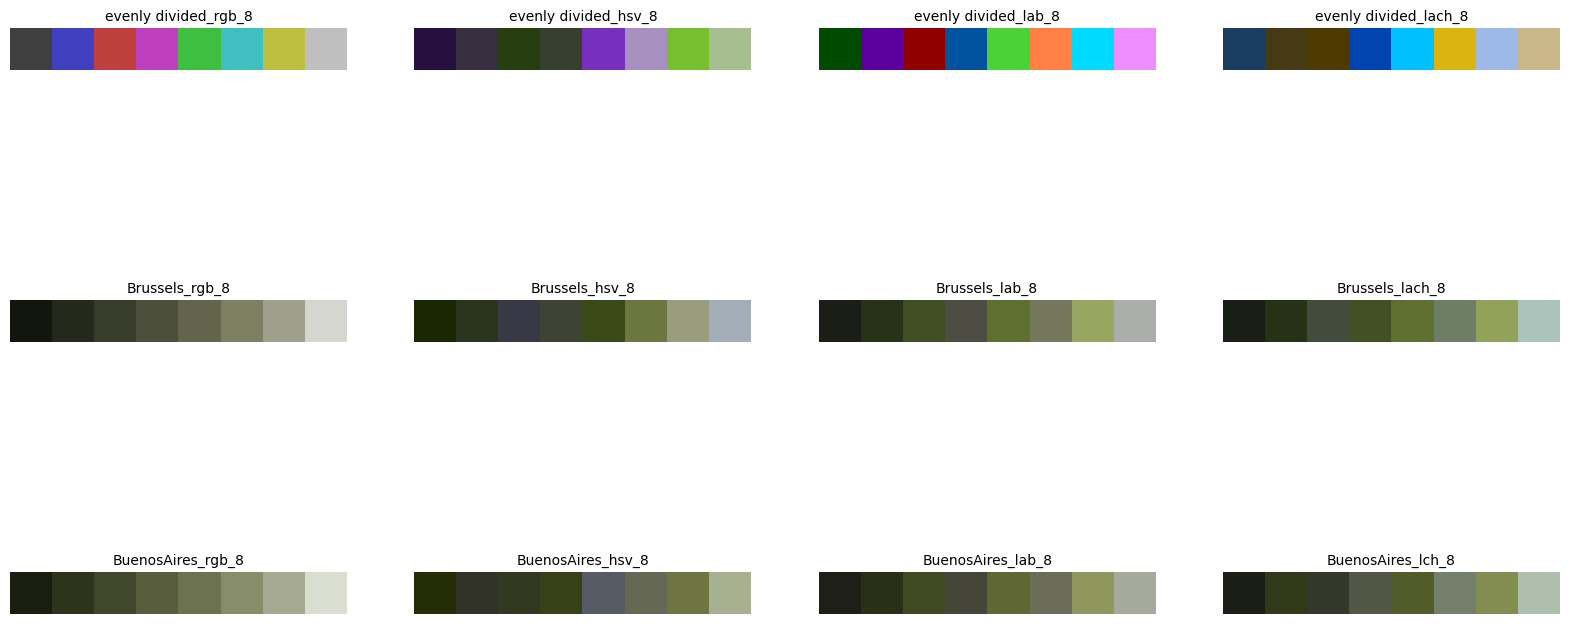

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(341), plt.imshow(sorted_colors_rgb/255),plt.axis('off'), plt.title('evenly divided_rgb_8', size=10)
plt.subplot(342),plt.imshow(sorted_colors_hsv), plt.axis('off'), plt.title('evenly divided_hsv_8', size=10)
plt.subplot(343), plt.imshow(sorted_colors_lab), plt.axis('off'), plt.title('evenly divided_lab_8', size=10)
plt.subplot(344),plt.imshow(sorted_colors_lch), plt.axis('off'), plt.title('evenly divided_lach_8', size=10)

plt.subplot(345), plt.imshow(sorted_Brus_8_rgb),plt.axis('off'), plt.title('Brussels_rgb_8', size=10)
plt.subplot(346),plt.imshow(sorted_Brus_8_hsv), plt.axis('off'), plt.title('Brussels_hsv_8', size=10)
plt.subplot(347), plt.imshow(sorted_Brus_8_lab), plt.axis('off'), plt.title('Brussels_lab_8', size=10)
plt.subplot(348),plt.imshow(sorted_Brus_8_lch), plt.axis('off'), plt.title('Brussels_lach_8', size=10)

plt.subplot(349), plt.imshow(sorted_Bru_8_rgb),plt.axis('off'), plt.title('BuenosAires_rgb_8', size=10)
plt.subplot(3,4,10),plt.imshow(sorted_Bru_8_hsv), plt.axis('off'), plt.title('BuenosAires_hsv_8', size=10)
plt.subplot(3,4,11), plt.imshow(sorted_Bru_8_lab), plt.axis('off'), plt.title('BuenosAires_lab_8', size=10)
plt.subplot(3,4,12),plt.imshow(sorted_Bru_8_lch), plt.axis('off'), plt.title('BuenosAires_lch_8', size=10)
#plt.savefig(f'E:/pythonproject/color_harmony/Result/HSV/Overall/treeandgrass_colorspacecomparsion_colorpalette_BrusandBue.png')
plt.show()

# JSON

In [15]:
json_reader = open("../Result/HSV/cities/treeandgrass/Boston_k_centers8-16.json", "r")
Boston_k = json.load(json_reader)
json_reader.close()
json_reader = open("../Result/HSV/cities/treeandgrass/Brussels_k_centers8-16.json", "r")
Bru_k = json.load(json_reader)
json_reader.close()
json_reader = open("../Result/HSV/cities/treeandgrass/LosAngeles_k_centers8-16.json", "r")
LA_k = json.load(json_reader)
json_reader.close()
json_reader = open("../Result/HSV/cities/treeandgrass/BuenosAires_k_centers8-16.json", "r")
BuenosAires_k = json.load(json_reader)
json_reader.close()


In [20]:
loss = []
for _ in range(9):
    LA_np = np.array(BuenosAires_k[_]) / 255
    BuenosAires_np = np.array(Bru_k[_]) / 255
    loss_k = np.sum(np.sqrt(np.sum((LA_np - BuenosAires_np)**2,axis=1)),axis= 0)

    loss.append(loss_k)

k = 14 最远